# Canny 算子边缘检测

## canny与sobel的区别：
sobel边缘检测算法两个步骤：首先用到sobel算子，提取灰度差值信息，也就是图像梯度值，然后用单阀值进一步提取边界信息。

canny边缘检测算法包含四个步骤：高斯滤波，同样计算灰度差值信息，即梯度信息和方向，后面检测边界信息这一块，不是用简单的单阈值方法，而是用了非极大值抑制法排除了不是边界点的信息，同时进一步用了双阈值法提取出强边界和弱边界，为最后做边界连接提供有用的边界点信息。

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay
import time
import cv2

## 下载Canny bitstream


In [2]:
canny_design = Overlay("canny.bit")

In [3]:
canny_design.ip_dict

{'axi_dma_0': {'fullpath': 'axi_dma_0',
  'type': 'xilinx.com:ip:axi_dma:7.1',
  'bdtype': None,
  'state': None,
  'addr_range': 65536,
  'phys_addr': 1077936128,
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '26',
   'C_M_AXI_SG_ADDR_WIDTH': '32',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '256',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   '

然后创建DMA 和 Canny IP 对象 

In [4]:
dma = canny_design.axi_dma_0
ctrl = canny_design.canny_edge_detection_0

导入图片

In [5]:
image_path = "lenna.png"
image = Image.open(image_path)

## 显示图像

Image size: 512x512 pixels.


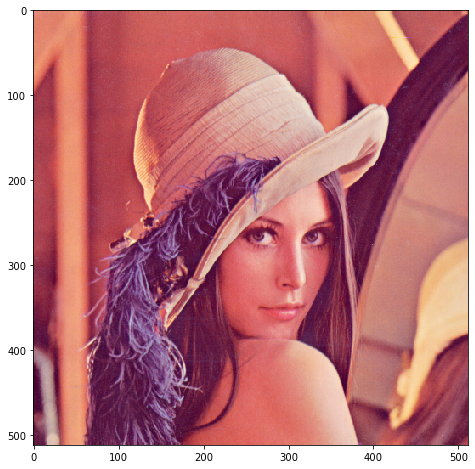

In [6]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = image.size
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(image)



## 分配内存

In [7]:
in_buffer = allocate(shape=(512,512,3), dtype='u1')
out_buffer = allocate(shape=(512,512,3), dtype='u1')

In [8]:
in_buffer[:] = np.array(image)

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    ctrl.write(0x0,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()


In [10]:
ctrl.write(0x10, 90)
ctrl.write(0x18, 10)

调整大小

In [11]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## 显示结果

Image size: 512x512 pixels.


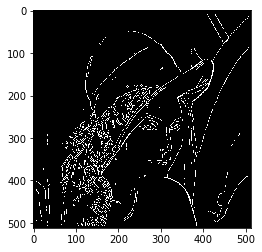

In [12]:
processed_image = Image.fromarray(out_buffer)
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(processed_image)
processed_image.save("out.png")